In [68]:
import pyart
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import xarray as xr
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
# Helper function used for visualization in the following examples
def identify_axes(ax_dict, fontsize=48):
    """
    Helper to identify the Axes in the examples below.

    Draws the label in a large font in the center of the Axes.

    Parameters
    ----------
    ax_dict : dict[str, Axes]
        Mapping between the title / label and the Axes.
    fontsize : int, optional
        How big the label should be.
    """
    kw = dict(ha="center", va="center", fontsize=fontsize, color="darkgrey")
    for k, ax in ax_dict.items():
        ax.text(0.5, 0.5, k, transform=ax.transAxes, **kw)

In [18]:
def subset_points(file, lats, lons, sites):
    """Subset a radar file for a set of latitudes and longitudes"""
    
    # Read in the file
    radar = pyart.io.read(file)
    
    column_list = []
    for lat, lon in zip(lats, lons):
        # Make sure we are interpolating from the radar's location above sea level
        #da = pyart.util.columnsect.get_field_location(radar, lat, lon).interp(height=np.arange(radar.altitude['data'][0], 10100, 100))
        da = pyart.util.columnsect.get_field_location(radar, lat, lon)
        # Add the latitude and longitude of the extracted column
        da["latitude"], da["longitude"] = lat, lon
        # Expand dimensions
        da = da.expand_dims("time")
        # Time is based off the start of the radar volume
        dt = pd.to_datetime(radar.time["units"].split(' ')[-1][:-1])
        da["time"] = [dt]
        # Make sure there are no duplicate height indices
        index = np.unique(da['height'], return_index=True)
        da = da.isel(height=index[1])
        # Append to the xrray dataset list. Interpolate heightsI'm so 
        column_list.append(da.interp(height=np.arange(100, 3000, 100)))
    # Concatenate the extracted radar columns for this scan across all sites    
    ds = xr.concat(column_list, dim='site')
    ds["site"] = sites
    # Add attributes for Time, Latitude, Longitude, and Sites
    #ds.time.attrs.update(long_name=('Time in Seconds that Cooresponds to the Start'
    #                                + " of each Individual Radar Volume Scan before"
    #                                + " Concatenation"),
    #                     units='seconds',
    #                     description=('Time in Seconds that Cooresponds to the Minimum'
    #                                  + ' Height Gate'))
    #ds.site.attrs.update(long_name="SAIL/SPLASH In-Situ Ground Observation Site Identifers")
    #ds.latitude.attrs.update(long_name='Latitude of SAIL Ground Observation Site',
    #                         units='Degrees North')
    #ds.longitude.attrs.update(long_name='Longitude of SAIL Ground Observation Site',
    #                         units='Degrees East')
    return ds

In [4]:
def match_datasets(column, ground, site, DataSet=False):
    """
    Time synchronization of a Ground Instrumentation Dataset to 
    a Radar Column for Specific Locations
    
    Parameters
    ----------
    column : Xarray DataSet
             Xarray DataSet containing the extracted radar column above multiple locations.
             Dimensions should include Time, Height, Site
             
    ground : str 
             String containing the path of the ground instrumentation file that is desired
             to be included within the extracted radar column dataset
             
    site : str
           Location of the ground instrument. Should be included within the filename. 
             
    Returns
    -------
    ds : Xarray DataSet
         Xarray Dataset containing the time-synced in-situ ground observations with
         the inputed radar column 
    """
    # Check to see if input is xarray DataSet or a file path
    if DataSet == True:
        grd_ds = ground
    else:
        # Read in the file
        grd_ds = xr.open_dataset(ground)

    # Resample the ground data to 5 min and interpolate to the CSU X-Band time. 
    # Keep data variable attributes to help distingish between instruments/locations
    matched = grd_ds.resample(time='5Min', closed='right').sum(keep_attrs=True).interp(time=column.time, method='linear') 
    
    # Add SAIL site location as a dimension for the Pluvio data
    matched = matched.assign_coords(coords=dict(site=site))
    matched = matched.expand_dims('site')
    
    # Remove Lat/Lon Data variables as it is included within the Matched Dataset with Site Identfiers
    if 'lat' in matched.data_vars:
        del matched['lat']
    if 'lon' in matched.data_vars:
        del matched['lon']
        
    # Update the individual Variables to Hold Global Attributes
    # global attributes will be lost on merging into the matched dataset.
    # Need to keep as many references and descriptors as possible
    for var in matched.data_vars:
        matched[var].attrs.update(platform_id=matched.platform_id)
        matched[var].attrs.update(data_level=matched.data_level)
        matched[var].attrs.update(location_description=matched.location_description)
        matched[var].attrs.update(datastream=matched.datastream)
        matched[var].attrs.update(doi=matched.doi)
        
    # Merge the two DataSets
    column = xr.merge([column, matched])
    
    # Tranpose the xarray DataSet to match the order of dimensions across all variables
    ##column = column.transpose("time", "height", "site")
    
    return column 

## Grab all the Data (Locally Stored)

In [5]:
file_list = sorted(glob.glob("/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/*"))
file_list[:10]

['/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_000056_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_000540_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_001029_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_001514_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_002105_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_002548_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_003037_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_003510_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_003938_V06',
 '/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_004407_V06']

In [6]:
ld_files = sorted(glob.glob("/Users/celsloaner/ARM/Observations/LD/TRACER/M1/*"))

## Extract the Radar Column above the TRACER M1 site. 

In [13]:
%%time
lats = [29.62]
lons = [-95.059]
sites = ["M1"]

ds_list = []
for file in file_list[:10]:
    if file[-3:] != "MDM":
        print(file)
        ds_list.append(subset_points(file, lats, lons, sites))

/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_000056_V06
<xarray.DataArray 'height' (height: 29)>
array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200,
       1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400,
       2500, 2600, 2700, 2800, 2900])
Coordinates:
  * height   (height) int64 100 200 300 400 500 600 ... 2500 2600 2700 2800 2900
Attributes:
    long_name:      Height of Radar Beam
    units:          m
    standard_name:  height
    description:    Height Above Sea Level [in meters] for the Center of Each...
/Users/celsloaner/ARM/Observations/NEXRAD/KHGX/2022/08/10/KHGX/KHGX20220810_000540_V06
<xarray.DataArray 'height' (height: 29)>
array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000, 1100, 1200,
       1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400,
       2500, 2600, 2700, 2800, 2900])
Coordinates:
  * height   (height) int64 100 200 300 400 500 600 ... 2500 2

In [14]:
ds = xr.concat(ds_list, dim='time')

## Match the Extracted Column to the Ground Laser Disdrometer

In [20]:
for lfile in ld_files:
    ds = match_datasets(ds, lfile, "M1")

/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfradial1' loading failed:
The 'dask' distribution was not found and is required by the application
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfradial2' loading failed:
The 'dask' distribution was not found and is required by the application
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'furuno' loading failed:
The 'dask' distribution was not found and is required by the application
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
/opt/anaconda3/envs/pyart-docs/lib/python3.6/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'gamic' loading failed:
Th

In [21]:
ds = ds.transpose("time", "height", "site", "particle_size", "raw_fall_velocity")

In [32]:
ds

<xarray.Dataset>
Dimensions:                               (height: 29, particle_size: 32, raw_fall_velocity: 32, site: 1, time: 10)
Coordinates:
  * time                                  (time) datetime64[ns] 2022-08-10T00...
  * height                                (height) int64 100 200 ... 2800 2900
  * site                                  (site) <U2 'M1'
  * particle_size                         (particle_size) float32 0.062 ... 24.0
  * raw_fall_velocity                     (raw_fall_velocity) float32 0.05 .....
Data variables: (12/48)
    differential_phase                    (time, height, site) float64 nan .....
    reflectivity                          (time, height, site) float64 nan .....
    differential_reflectivity             (time, height, site) float64 nan .....
    cross_correlation_ratio               (time, height, site) float64 nan .....
    spectrum_width                        (time, height, site) float64 nan .....
    clutter_filter_power_removed          (time, height, site) float64 nan .....
    ...                                    ...
    moment2                               (time, site) float64 0.0 0.0 ... 0.0
    moment3                               (time, site) float64 0.0 0.0 ... 0.0
    moment4                               (time, site) float64 0.0 0.0 ... 0.0
    moment5                               (time, site) float64 0.0 0.0 ... 0.0
    moment6                               (time, site) float64 0.0 0.0 ... 0.0
    alt                                   (time, site) float64 8.0 8.0 ... 8.0
Attributes:
    distance_from_radar:    16.578 km
    azimuth:                6.608 degrees
    latitude_of_location:   29.62 degrees
    longitude_of_location:  -95.059 degrees

## Plot the Radar Loops

In [ ]:
for file in file_list:
    print(file)

In [27]:
radar = pyart.io.read(file_list[0])

In [28]:
display = pyart.graph.RadarMapDisplay(radar)

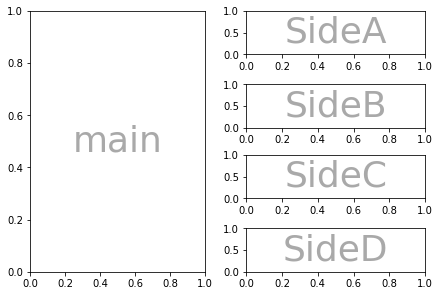

In [25]:
inner = [
    ["SideA"],
    ["SideB"],
]

bottom = [
    ["SideC"],
    ["SideD"],
]

outer_nested_mosaic = [
    ["main", inner],
    ["main", bottom],
]
axd = plt.figure(constrained_layout=True).subplot_mosaic(
    outer_nested_mosaic, empty_sentinel=None
)
identify_axes(axd, fontsize=36)

In [109]:
inner = [
    ["SideA"],
    ["SideB"],
]

bottom = [
    ["SideC"],
    ["SideD"],
]

outer_nested_mosaic = [
    ["main", inner],
    ["main", bottom],
]

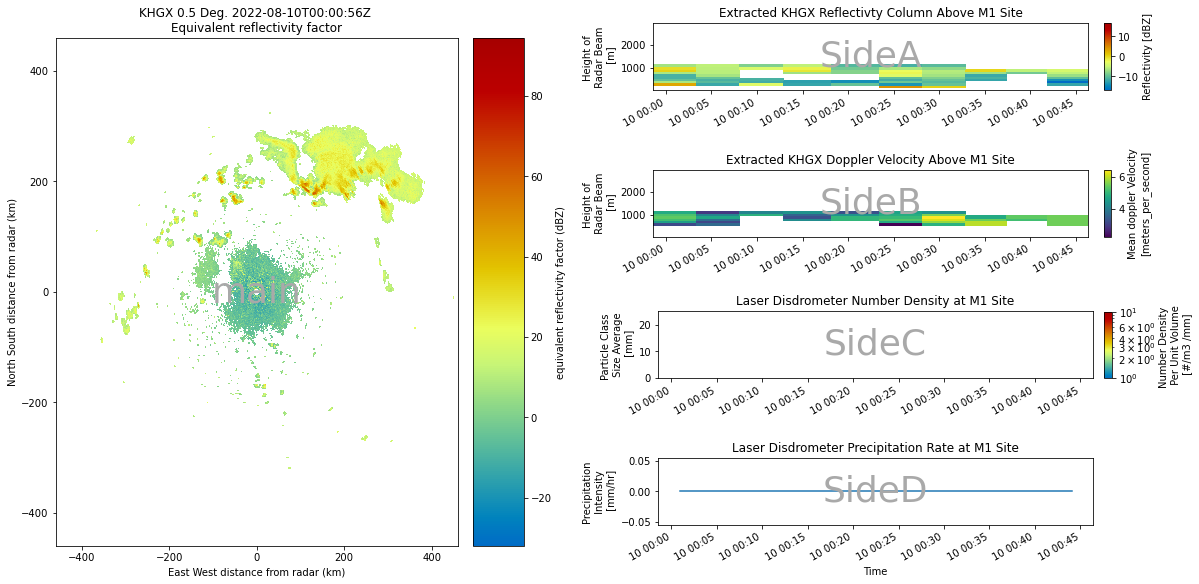

In [165]:
fig, axd = plt.subplot_mosaic(outer_nested_mosaic,
                              figsize=(16, 8), constrained_layout=True)

#axd = plt.figure(constrained_layout=True, figsize=[16, 8]).subplot_mosaic(
#    outer_nested_mosaic, empty_sentinel=None
#)
identify_axes(axd, fontsize=36)

# Main Display - Reflectivity Loop
display.plot_ppi('reflectivity', sweep=0, ax=axd['main'])

# Side A - Column Extract - Reflectivity
reflect = ds.sel(site='M1').reflectivity.plot(x='time',
                                              ax=axd['SideA'], 
                                              cmap='pyart_HomeyerRainbow',
                                              add_colorbar=True)
#divider = make_axes_locatable(axd['SideA'])
#cbax = divider.append_axes("right", size="3%", pad=0.5)
axd['SideA'].set_xlabel(' ')
axd['SideA'].set_ylabel('Height of \n Radar Beam \n [m]')
axd['SideA'].set_title("Extracted KHGX Reflectivty Column Above M1 Site")
#axd.colorbar(reflect, orientation="vertical", ax=axd['SideA'], cax=cbax)
#axd['SideA'].xaxis.set_visible(False)
#axd['SideA'].grid(axis='both')

# Side B - Column Extract - Velocity 
ds.sel(site='M1').velocity.plot(x='time', ax=axd['SideB'], add_colorbar=True)
axd['SideB'].sharex(axd['SideA'])
axd['SideB'].set_ylabel('Height of \n Radar Beam \n [m]')
axd['SideB'].set_xlabel(' ')
axd['SideB'].set_title("Extracted KHGX Doppler Velocity Above M1 Site")
#axd['SideB'].xaxis.set_visible(False)

# Side C - Laser Disdrometer - PSD
# Drop Size Distribution
norm = colors.LogNorm(vmin=ds.number_density_drops.values.min()+1,
                      vmax=ds.number_density_drops.values.max()+10)

psd = ds.sel(site="M1").number_density_drops.plot(x='time', 
                                                  norm=norm, 
                                                  cmap='pyart_HomeyerRainbow',
                                                  add_colorbar=False,
                                                  ax=axd['SideC'])
divider = make_axes_locatable(axd['SideC'])
cax = divider.append_axes("right", size="3%", pad=0.7)
cax.set_visible(False)
#cbax = divider.append_axes("right", size="3%")
cbax = fig.add_axes([0.955, 0.35, 0.007, 0.115])
cbar2 = fig.colorbar(psd, orientation="vertical", cax=cbax)
cbar2.set_label('Number Density \n Per Unit Volume \n [#/m3 /mm]')
axd['SideC'].sharex(axd['SideA'])
axd['SideC'].set_title("Laser Disdrometer Number Density at M1 Site")
axd['SideC'].set_ylabel("Particle Class \n Size Average \n [mm]")
axd['SideC'].set_xlabel(" ")

# Side D - Laser Disdrometer - Precipitation Rate
ds.sel(site="M1").precip_rate.plot(x='time', ax=axd['SideD'])
axd['SideD'].sharex(axd['SideA'])
axd['SideD'].set_title("Laser Disdrometer Precipitation Rate at M1 Site")
#axd['SideD'].set_ylabel("Particle Class \n Size Average \n [mm]")
axd['SideD'].set_xlabel("Time")
axd['SideD'].set_ylabel("Precipitation \n Intensity \n [mm/hr]")
divider = make_axes_locatable(axd['SideD'])
cax = divider.append_axes("right", size="3%", pad=0.7)
cax.set_visible(False)